<a href="https://colab.research.google.com/github/shahd1995913/Combining-Semantic-Web-and-Machine-Learning-for-Representing-and-Manipulating-Point-Cloud-Data/blob/main/Combining_Semantic_Web_and_Machine_Learning_for_Representing_and_Manipulating_Point_Cloud_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install open3d scikit-learn rdflib matplotlib pandas

import open3d as o3d
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import urllib.request
import tempfile


In [13]:
# -------------------------
#1. Download Point Cloud from the Internet (PLY)
url = "https://people.sc.fsu.edu/~jburkardt/data/ply/balance.ply"

# # Temporarily save to device
tmp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".ply")
with urllib.request.urlopen(url) as response:
    tmp_file.write(response.read())
tmp_file.close()

# Reading data
pcd = o3d.io.read_point_cloud(tmp_file.name)
points = np.asarray(pcd.points)
print("Number of points:", points.shape[0])

Number of points: 1288


In [14]:
# -------------------------
# 2. Create Semantic Web data for each point
g = Graph()
EX = Namespace("http://example.org/pointcloud/")

for i, (x, y, z) in enumerate(points):
    point_uri = URIRef(EX[f"point{i}"])
    g.add((point_uri, RDF.type, EX.Point))
    g.add((point_uri, EX.height, Literal(z)))
    # Example for classifying surface type
    surface_type = "high" if z > np.mean(points[:,2]) else "low"
    g.add((point_uri, EX.surface, Literal(surface_type)))

# -------------------------
# 3. Convert semantic data into numerical features
surface_map = {"low": 0, "high": 1}
semantic_features = []
for i in range(points.shape[0]):
    z = points[i, 2]
    surface_type = "high" if z > np.mean(points[:,2]) else "low"
    semantic_features.append([z, surface_map[surface_type]])

semantic_features = np.array(semantic_features)

# -------------------------
# 4. Apply KMeans using semantic features
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(semantic_features)

# -------------------------
# 5. Color points according to clusters
colors = plt.get_cmap("tab10")(labels / n_clusters)[:, :3]
pcd.colors = o3d.utility.Vector3dVector(colors)

# -------------------------
# 6. Visualize results
o3d.visualization.draw_geometries([pcd], window_name="Semantic + ML Clustering")

# -------------------------
# 7. Show cluster centers
print("Cluster centers (using semantic features):\n", kmeans.cluster_centers_)


[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Cluster centers (using semantic features):
 [[ 4.51648424e+01  1.11111111e-01]
 [ 1.12068475e+02  1.00000000e+00]
 [ 6.85078621e+00 -1.16573418e-15]]


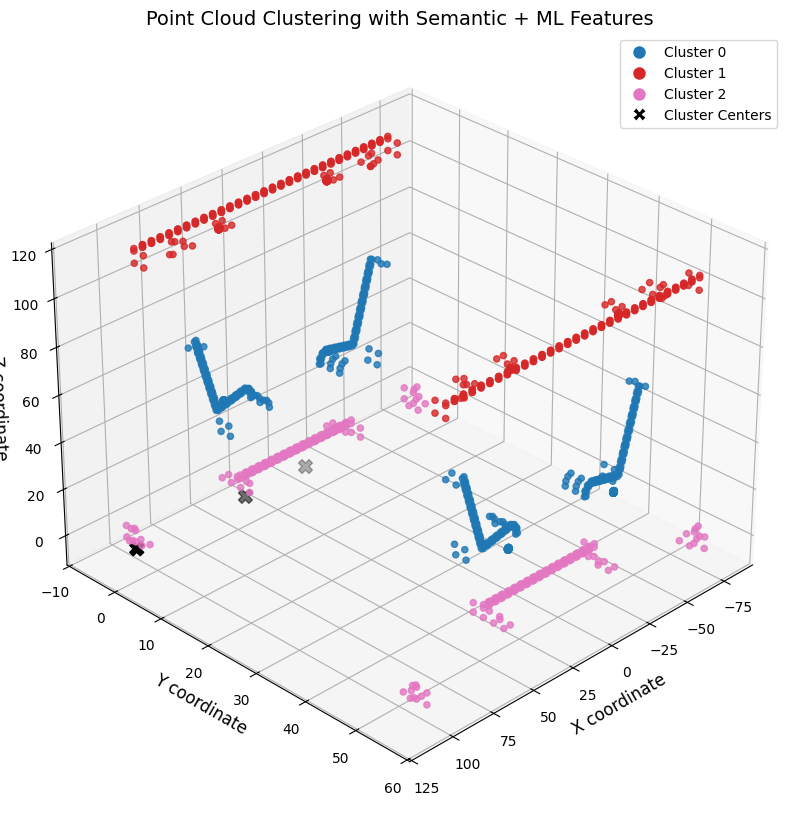

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert points to numpy array
points = np.asarray(pcd.points)

# Map cluster labels to colors (tab10)
cluster_colors = plt.get_cmap("tab10")(labels / n_clusters)

# Create 3D figure
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter points with transparency
scatter = ax.scatter(
    points[:,0], points[:,1], points[:,2],
    c=cluster_colors, s=20, alpha=0.8
)

# Plot cluster centers
centers = kmeans.cluster_centers_
ax.scatter(
    centers[:,0], centers[:,0]*0, centers[:,1],  # Adjust to match features if needed
    c='black', s=100, marker='X', label='Cluster Centers'
)

# Labels and title
ax.set_xlabel('X coordinate', fontsize=12)
ax.set_ylabel('Y coordinate', fontsize=12)
ax.set_zlabel('Z coordinate', fontsize=12)
ax.set_title('Point Cloud Clustering with Semantic + ML Features', fontsize=14)

# Add legend for clusters
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=f'Cluster {i}', markerfacecolor=plt.get_cmap("tab10")(i/n_clusters), markersize=10)
                   for i in range(n_clusters)]
legend_elements.append(Line2D([0], [0], marker='X', color='w', label='Cluster Centers', markerfacecolor='black', markersize=10))
ax.legend(handles=legend_elements)

# Rotate for better view
ax.view_init(elev=30, azim=45)

plt.show()


RDF Graph created successfully!
Total triples in graph: 800


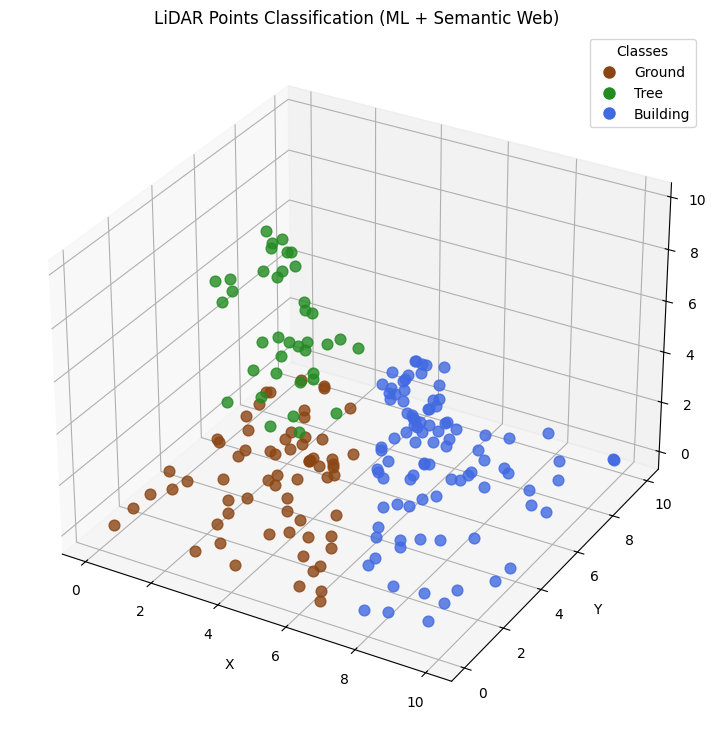

In [9]:
# Install required libraries
# !pip install rdflib scikit-learn matplotlib

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, URIRef, Literal

# ------------------------
# 1. Create synthetic LiDAR point cloud data
# ------------------------
# Points representing ground, tree, and building
ground = np.random.rand(100,3) * [10, 10, 0.2]          # Ground
tree = np.random.rand(50,3) * [2, 2, 5] + [5,5,0]       # Tree
building = np.random.rand(50,3) * [3, 3, 10] + [2,2,0]  # Building

points = np.vstack([ground, tree, building])

# ------------------------
# 2. Classify points using KMeans (ML example)
# ------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(points)

# ------------------------
# 3. Represent points in Semantic Web (RDF Graph)
# ------------------------
g = Graph()
EX = Namespace("http://example.org/")

for i, point in enumerate(points):
    point_uri = URIRef(f"http://example.org/point{i}")
    g.add((point_uri, EX.hasX, Literal(float(point[0]))))
    g.add((point_uri, EX.hasY, Literal(float(point[1]))))
    g.add((point_uri, EX.hasZ, Literal(float(point[2]))))
    g.add((point_uri, EX.hasClass, Literal(int(labels[i]))))

print("RDF Graph created successfully!")
print(f"Total triples in graph: {len(g)}")

# ------------------------
# 4. Plot classified points in 3D clearly
# ------------------------
colors = ['saddlebrown','forestgreen','royalblue']
class_names = ['Ground','Tree','Building']

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

for i, point in enumerate(points):
    ax.scatter(point[0], point[1], point[2], color=colors[labels[i]], s=60, alpha=0.8)

# Add legend
handles = [plt.Line2D([0],[0], marker='o', color='w', label=class_names[i],
                      markerfacecolor=colors[i], markersize=10) for i in range(3)]
ax.legend(handles=handles, title="Classes")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("LiDAR Points Classification (ML + Semantic Web)")
plt.show()


RDF Graph created successfully!
Total triples in graph: 1650


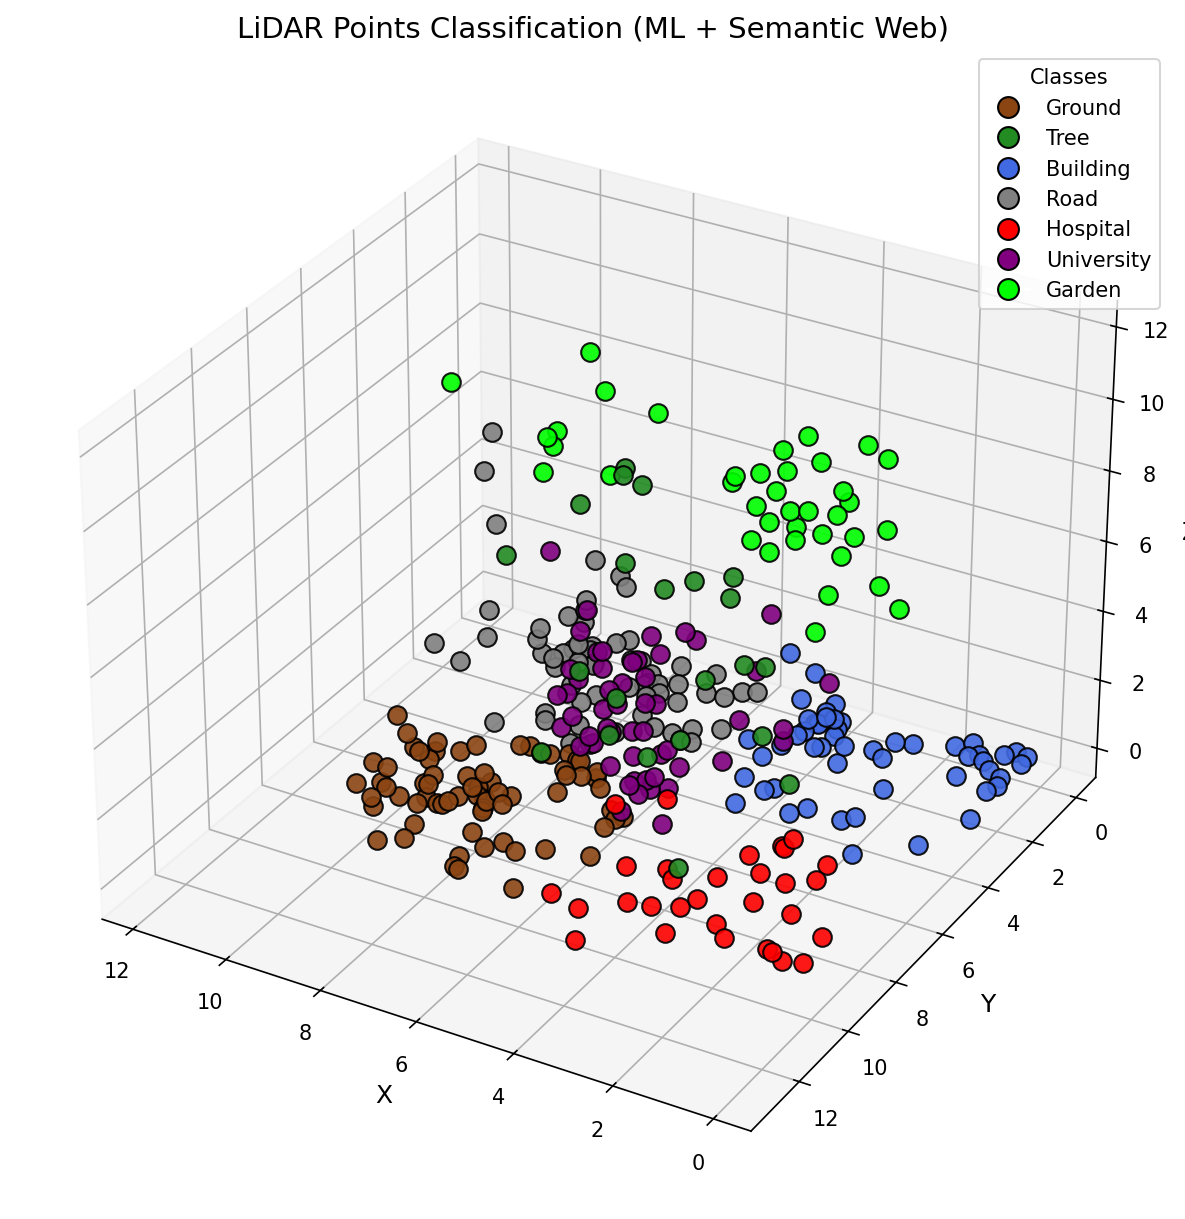

In [11]:
# Install required libraries
# !pip install rdflib scikit-learn matplotlib

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, URIRef, Literal

# ------------------------
# 1. Create synthetic LiDAR points with multiple semantic features
# ------------------------
ground = np.random.rand(100,3) * [10, 10, 0.2]              # Ground
tree = np.random.rand(50,3) * [2, 2, 5] + [5,5,0]           # Tree
building = np.random.rand(50,3) * [3, 3, 10] + [2,2,0]      # Building
road = np.random.rand(40,3) * [10, 2, 0.1] + [0,0,0]        # Road
hospital = np.random.rand(30,3) * [4, 4, 10] + [8,0,0]      # Hospital
university = np.random.rand(30,3) * [5, 5, 12] + [0,8,0]    # University
garden = np.random.rand(30,3) * [3, 3, 2] + [7,7,0]         # Garden

points = np.vstack([ground, tree, building, road, hospital, university, garden])

# ------------------------
# 2. Apply ML clustering (KMeans)
# ------------------------
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(points)

# ------------------------
# 3. Create Semantic Web RDF graph
# ------------------------
g = Graph()
EX = Namespace("http://example.org/")

semantic_types = ['Ground']*100 + ['Tree']*50 + ['Building']*50 + ['Road']*40 + \
                 ['Hospital']*30 + ['University']*30 + ['Garden']*30

for i, point in enumerate(points):
    point_uri = URIRef(f"http://example.org/point{i}")
    g.add((point_uri, EX.hasX, Literal(float(point[0]))))
    g.add((point_uri, EX.hasY, Literal(float(point[1]))))
    g.add((point_uri, EX.hasZ, Literal(float(point[2]))))
    g.add((point_uri, EX.hasClass, Literal(int(labels[i]))))
    g.add((point_uri, EX.hasType, Literal(semantic_types[i])))

print("RDF Graph created successfully!")
print(f"Total triples in graph: {len(g)}")

# ------------------------
# 4. Plot 3D point cloud with clearer, retina-quality visualization
# ------------------------
from mpl_toolkits.mplot3d import Axes3D

colors = ['saddlebrown','forestgreen','royalblue','gray','red','purple','lime']
class_names = ['Ground','Tree','Building','Road','Hospital','University','Garden']

fig = plt.figure(figsize=(14,10), dpi=150)  # larger figure & higher DPI for retina quality
ax = fig.add_subplot(111, projection='3d')

# Scatter points with bigger size and some transparency
for i, point in enumerate(points):
    ax.scatter(point[0], point[1], point[2], color=colors[labels[i]%7], s=80, alpha=0.9, edgecolor='k')

# Add legend
handles = [plt.Line2D([0],[0], marker='o', color='w', label=class_names[i],
                      markerfacecolor=colors[i], markersize=10, markeredgecolor='k') for i in range(7)]
ax.legend(handles=handles, title="Classes", fontsize=10)

# Set axis labels and title with larger font
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title("LiDAR Points Classification (ML + Semantic Web)", fontsize=14)

# Improve grid and viewing angle
ax.grid(True)
ax.view_init(elev=30, azim=120)  # adjust angle for better visibility

plt.show()
